# Credit Card Fraud Detection - Modeling

## Table of Contents
1. <a href="#1-import-and-load-data">Import and load data</a>
2. <a href="#2-implement-evaluation-metrics">Implement Evaluation Metrics</a>
3. <a href="#3-model-logistic-regression">Model: Logistic Regression</a>
    - 3.1. <a href="#31-introduction-to-logistic-regression">Introduction to Logistic Regression</a>
    - 3.2. <a href="#32-class-setting">Class Setting</a>
    - 3.3. <a href="#33-training-analysis">Training Analysis</a>
    - 3.4. <a href="#34-test-and-evaluate">Test and Evaluate</a>
        - 3.4.1. <a href="#341-quantitative-metrics-analysis">Quantitative Metrics Analysis</a>
        - 3.4.2. <a href="#342-confusion-matrix-analysis">Confusion Matrix Analysis</a>
        - 3.4.3. <a href="#343-roc-curve-and-auc-analysis">ROC Curve and AUC Analysis</a>

## 1. Import and load data

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

np.set_printoptions(suppress=True)

X_train = np.load('../data/processed/X_train.npy')
X_test = np.load('../data/processed/X_test.npy')
y_train = np.load('../data/processed/y_train.npy')
y_test = np.load('../data/processed/y_test.npy')

## 2. Implement Evaluation Metrics

Trong bài toán phát hiện gian lận (dữ liệu mất cân bằng), độ chính xác (Accuracy) không phải là thước đo tốt. Chúng ta sẽ tập trung vào các chỉ số sau:

* **Precision (Độ chính xác dương tính):** Trong số các giao dịch mô hình dự đoán là gian lận, bao nhiêu phần trăm là đúng? (Tránh làm phiền khách hàng bằng các cảnh báo giả).
* **Recall (Độ nhạy):** Mô hình phát hiện được bao nhiêu phần trăm tổng số vụ gian lận thực tế? (Tránh bỏ lọt tội phạm).
* **F1-Score:** Trung bình điều hòa giữa Precision và Recall.
* **AUPRC (Area Under Precision-Recall Curve):** Chỉ số quan trọng nhất cho dữ liệu mất cân bằng, đo lường khả năng phân loại tốt mà không phụ thuộc vào ngưỡng (threshold).
* **Confusion Matrix:** Cho cái nhìn trực quan về số lượng False Positives và False Negatives.

In [3]:
def accuracy_score(y_true, y_pred):
    return np.mean(y_true == y_pred)

def confusion_matrix(y_true, y_pred):
    # Binary classification: 0 = negative, 1 = positive
    tn = np.sum((y_true == 0) & (y_pred == 0))
    fp = np.sum((y_true == 0) & (y_pred == 1))
    fn = np.sum((y_true == 1) & (y_pred == 0))
    tp = np.sum((y_true == 1) & (y_pred == 1))
    
    return np.array([[tn, fp], [fn, tp]])

def precision_score(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    tp = cm[1, 1]
    fp = cm[0, 1]
    
    if tp + fp == 0:
        return 0.0
    return tp / (tp + fp)

def recall_score(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    tp = cm[1, 1]
    fn = cm[1, 0]
    
    if tp + fn == 0:
        return 0.0
    return tp / (tp + fn)

def f1_score(y_true, y_pred):
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    
    if precision + recall == 0:
        return 0.0
    return 2 * (precision * recall) / (precision + recall)

def roc_curve(y_true, y_scores):
    sorted_indices = np.argsort(y_scores)[::-1]
    y_true_sorted = y_true[sorted_indices]
    y_scores_sorted = y_scores[sorted_indices]
    
    thresholds = np.unique(y_scores_sorted)
    thresholds = np.append(thresholds, thresholds[-1] + 1)
    
    fpr = []
    tpr = []
    
    for threshold in thresholds:
        y_pred = (y_scores_sorted >= threshold).astype(int)
        cm = confusion_matrix(y_true_sorted, y_pred)
        
        tn, fp = cm[0, 0], cm[0, 1]
        fn, tp = cm[1, 0], cm[1, 1]
        
        # False Positive Rate
        fpr_val = fp / (fp + tn) if (fp + tn) > 0 else 0.0
        # True Positive Rate (Recall)
        tpr_val = tp / (tp + fn) if (tp + fn) > 0 else 0.0
        
        fpr.append(fpr_val)
        tpr.append(tpr_val)
    
    return np.array(fpr), np.array(tpr), thresholds

def auc_score(fpr, tpr):
    sorted_indices = np.argsort(fpr)
    fpr_sorted = fpr[sorted_indices]
    tpr_sorted = tpr[sorted_indices]
    
    auc = np.trapz(tpr_sorted, fpr_sorted)
    return auc

## 3. Model: Logistic Regression

### 3.1. Giới thiệu thuật toán

**Logistic Regression** là một thuật toán phân loại sử dụng hàm sigmoid để dự đoán xác suất:

$$P(y=1|x) = \frac{1}{1 + e^{-(w^T x + b)}}$$

**Loss function** (Binary Cross-Entropy):
$$L = -\frac{1}{m}\sum_{i=1}^{m}[y_i \log(\hat{y}_i) + (1-y_i)\log(1-\hat{y}_i)]$$

**Gradient descent** để cập nhật weights:
$$\frac{\partial L}{\partial w} = \frac{1}{m}X^T(\hat{y} - y)$$
$$\frac{\partial L}{\partial b} = \frac{1}{m}\sum(\hat{y} - y)$$

### 3.2. Class Setting

In [4]:
class LogisticRegression:
    def __init__(self, learning_rate=0.01, max_iter=1000, tol=1e-6, random_state=None):
        self.learning_rate = learning_rate
        self.max_iter = max_iter
        self.tol = tol
        self.random_state = random_state
        self.weights = None
        self.bias = None
        self.loss_history = []
        
    def _sigmoid(self, z):
        z = np.clip(z, -500, 500)
        return 1 / (1 + np.exp(-z))
    
    def _binary_cross_entropy_loss(self, y_true, y_pred):
        loss = -np.mean(y_true * np.log(y_pred + 1e-15) + (1 - y_true) * np.log(1 - y_pred + 1e-15))
        return loss
    
    def fit(self, X, y):
        if self.random_state is not None:
            np.random.seed(self.random_state)
        
        m, n = X.shape
        
        self.weights = np.random.randn(n) * 0.01
        self.bias = 0.0
        
        X_with_bias = np.column_stack([np.ones(m), X])
        weights_with_bias = np.append(self.bias, self.weights)
        
        for i in range(self.max_iter):
            z = X_with_bias @ weights_with_bias
            y_pred = self._sigmoid(z)
            
            loss = -np.mean(y * np.log(y_pred + 1e-15) + (1 - y) * np.log(1 - y_pred + 1e-15))
            self.loss_history.append(loss)
            
            dw = (1/m) * np.einsum('ji,j->i', X, (y_pred - y))
            db = (1/m) * np.sum(y_pred - y)
            
            self.weights -= self.learning_rate * dw
            self.bias -= self.learning_rate * db
            
            weights_with_bias = np.append(self.bias, self.weights)
            
            if i > 0 and abs(self.loss_history[-2] - self.loss_history[-1]) < self.tol:
                print(f"Converged at iteration {i+1}")
                break
    
    def predict_proba(self, X):
        m = X.shape[0]
        X_with_bias = np.column_stack([np.ones(m), X])
        weights_with_bias = np.append(self.bias, self.weights)
        
        z = X_with_bias @ weights_with_bias
        probabilities = self._sigmoid(z)
        
        return probabilities
    
    def predict(self, X, threshold=0.5):
        probabilities = self.predict_proba(X)
        return (probabilities >= threshold).astype(int)

### 3.3. Training Analysis

Training completed!
Number of iterations: 1000
Final loss: 0.10950457
Weights shape: (30,)
Bias: -2.169684


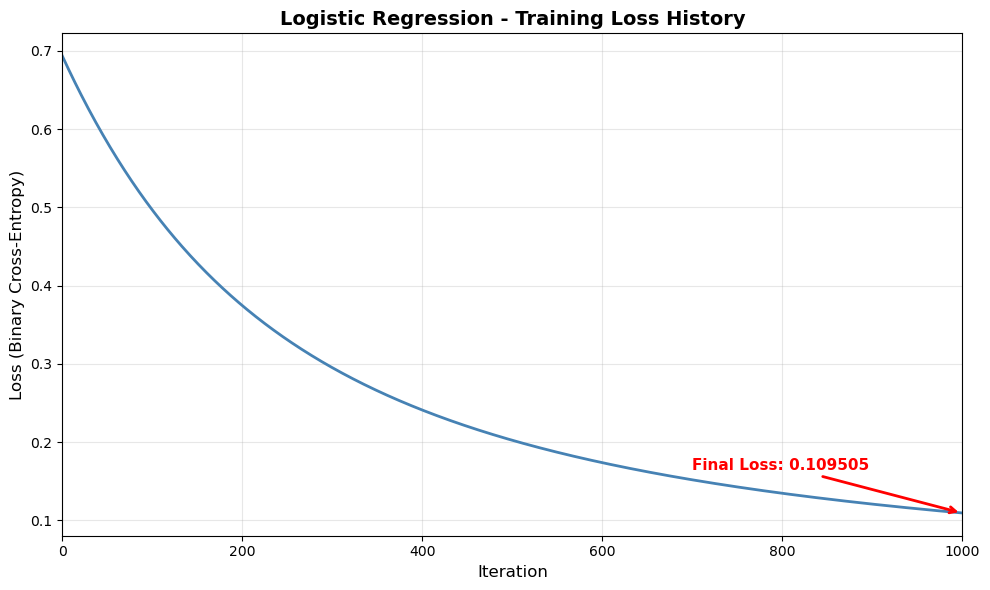

In [5]:
lr_model = LogisticRegression(learning_rate=0.01, max_iter=1000, tol=1e-6, random_state=42)
lr_model.fit(X_train, y_train)

print(f"Training completed!")
print(f"Number of iterations: {len(lr_model.loss_history)}")
print(f"Final loss: {lr_model.loss_history[-1]:.8f}")
print(f"Weights shape: {lr_model.weights.shape}")
print(f"Bias: {lr_model.bias:.6f}")

fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(lr_model.loss_history, linewidth=2, color='steelblue')
ax.set_xlabel('Iteration', fontsize=12)
ax.set_ylabel('Loss (Binary Cross-Entropy)', fontsize=12)
ax.set_title('Logistic Regression - Training Loss History', fontsize=14, fontweight='bold')
ax.grid(alpha=0.3)
ax.set_xlim([0, len(lr_model.loss_history)])

final_loss = lr_model.loss_history[-1]
ax.annotate(f'Final Loss: {final_loss:.6f}', 
           xy=(len(lr_model.loss_history)-1, final_loss),
           xytext=(len(lr_model.loss_history)*0.7, final_loss*1.5),
           arrowprops=dict(arrowstyle='->', color='red', lw=2),
           fontsize=11, fontweight='bold', color='red')

plt.tight_layout()
plt.show()

#### Phân tích quá trình huấn luyện

Dựa vào biểu đồ **Training Loss History** và thông số cuối cùng:
* **Sự hội tụ (Convergence):** Đường Loss giảm đều và mượt mà, tiệm cận về giá trị ~0.1095 sau 1000 vòng lặp. Điều này chứng tỏ thuật toán Gradient Descent hoạt động đúng, Learning Rate `0.01` là phù hợp (không bị dao động quá mạnh hay hội tụ quá chậm).
* **Underfitting/Overfitting:** Mức loss này khá thấp đối với bài toán phân loại nhị phân, cho thấy mô hình đã học được các đặc trưng từ dữ liệu huấn luyện. Tuy nhiên, để khẳng định mô hình có bị Overfitting hay không, chúng ta cần xem xét kết quả trên tập Test ở phần tiếp theo.

### 3.4. Test and Evaluate

### Từ dự đoán của mô hình, chúng ta có thể thấy được gì về khả năng phát hiện gian lận?

#### 3.4.1. Quantitative Metrics Analysis

In [13]:
print("=== Logistic Regression - Prediction ===")
print("Using threshold = 0.5")
y_pred_lr = lr_model.predict(X_test)
y_pred_proba_lr = lr_model.predict_proba(X_test)

acc_lr = accuracy_score(y_test, y_pred_lr)
prec_lr = precision_score(y_test, y_pred_lr)
rec_lr = recall_score(y_test, y_pred_lr)
f1_lr = f1_score(y_test, y_pred_lr)

print("\nTest Results:")
print(f"Accuracy:  {acc_lr:.4f}")
print(f"Precision: {prec_lr:.4f}")
print(f"Recall:    {rec_lr:.4f}")
print(f"F1-Score:  {f1_lr:.4f}")

=== Logistic Regression - Prediction ===
Using threshold = 0.5

Test Results:
Accuracy:  0.9989
Precision: 0.8333
Recall:    0.4592
F1-Score:  0.5921


Kết quả trên tập Test cho thấy một bức tranh rõ ràng về bài toán mất cân bằng dữ liệu:



1.  **Accuracy (0.9989):** Rất cao, nhưng **vô nghĩa** trong ngữ cảnh này. Vì số lượng giao dịch bình thường chiếm đa số, mô hình chỉ cần dự đoán tất cả là "Bình thường" cũng có thể đạt accuracy > 99%.

2.  **Precision (0.8333):** Khá tốt. Có nghĩa là khi mô hình cảnh báo "Đây là lừa đảo", thì 83.33% khả năng đó đúng là lừa đảo. Điều này giúp giảm thiểu việc làm phiền khách hàng (False Positive thấp).

3.  **Recall (0.4592):** **Đây là vấn đề cần quan tâm.** Chỉ số này cho biết mô hình chỉ phát hiện được khoảng **46%** tổng số vụ gian lận thực tế. Hơn 54% số vụ gian lận đã bị bỏ lọt (False Negative cao).

4.  **F1-Score (0.5921):** Phản ánh sự đánh đổi giữa Precision và Recall. Mức điểm này ở mức trung bình, bị kéo xuống do Recall thấp.



**Nhận định:** Với Logistic Regression cơ bản và ngưỡng (threshold) mặc định là 0.5, mô hình đang an toàn quá mức (thiên về Precision) và bỏ sót nhiều tội phạm (Recall thấp).

In [14]:
print("=== Logistic Regression - Prediction ===")
print("Using threshold = 0.2")
y_pred_lr = lr_model.predict(X_test, threshold=0.2)
y_pred_proba_lr = lr_model.predict_proba(X_test)

acc_lr = accuracy_score(y_test, y_pred_lr)
prec_lr = precision_score(y_test, y_pred_lr)
rec_lr = recall_score(y_test, y_pred_lr)
f1_lr = f1_score(y_test, y_pred_lr)

print("\nTest Results:")
print(f"Accuracy:  {acc_lr:.4f}")
print(f"Precision: {prec_lr:.4f}")
print(f"Recall:    {rec_lr:.4f}")
print(f"F1-Score:  {f1_lr:.4f}")

=== Logistic Regression - Prediction ===
Using threshold = 0.2

Test Results:
Accuracy:  0.9993
Precision: 0.8041
Recall:    0.7959
F1-Score:  0.8000


Việc hạ ngưỡng quyết định từ mặc định (0.5) xuống **0.2** (tức là chỉ cần mô hình nghi ngờ >20% là sẽ gắn nhãn Gian lận) đã mang lại sự **cải thiện đột phá**:

1.  **Recall (0.7959): Cải thiện ấn tượng nhất.**
    * *So sánh:* Tăng vọt từ ~46% lên gần **80%**.
    * *Ý nghĩa:* Trước đây mô hình bỏ sót hơn một nửa số vụ gian lận, giờ đây nó đã bắt được 4/5 số vụ. Trong nghiệp vụ ngân hàng, việc giảm thiểu rủi ro bỏ lọt tội phạm (giảm False Negative) là ưu tiên hàng đầu, và sự thay đổi này cực kỳ giá trị.

2.  **Precision (0.8041): Sự đánh đổi chấp nhận được.**
    * *So sánh:* Giảm nhẹ từ ~83% xuống **80%**.
    * *Ý nghĩa:* Khi chúng ta làm mô hình "nhạy cảm" hơn (dễ báo gian lận hơn), việc báo nhầm (False Positive) tăng lên là điều tất yếu. Tuy nhiên, mức giảm này rất nhỏ. Độ chính xác 80% nghĩa là cứ 10 cảnh báo thì vẫn có 8 trường hợp là đúng. Đây là tỷ lệ rất tốt để đội ngũ vận hành kiểm tra lại mà không bị quá tải (alert fatigue).

3.  **F1-Score (0.8000): Cân bằng tốt hơn.**
    * *So sánh:* Tăng mạnh từ ~0.59 lên **0.80**.
    * *Ý nghĩa:* F1-Score cao chứng tỏ mô hình hiện tại đã cân bằng rất tốt giữa việc "bắt đúng" và "không bắt nhầm". Đây là cấu hình tốt hơn hẳn so với threshold 0.5.

4.  **Accuracy (0.9993):** Vẫn duy trì ở mức cực cao, thậm chí nhỉnh hơn một chút, cho thấy mô hình phân loại tốt cả hai lớp đa số và thiểu số.

#### 3.4.2. Confusion Matrix Analysis

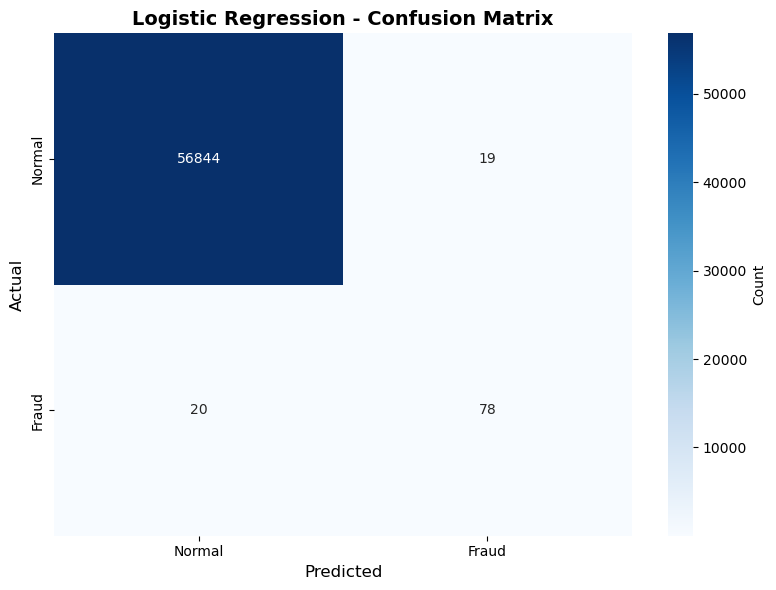

In [15]:
cm_lr = confusion_matrix(y_test, y_pred_lr)
fig, ax = plt.subplots(figsize=(8, 6))
sns.heatmap(cm_lr, annot=True, fmt='d', cmap='Blues', 
           xticklabels=['Normal', 'Fraud'],
           yticklabels=['Normal', 'Fraud'],
           ax=ax, cbar_kws={'label': 'Count'})
ax.set_xlabel('Predicted', fontsize=12)
ax.set_ylabel('Actual', fontsize=12)
ax.set_title('Logistic Regression - Confusion Matrix', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

### 1. Phân tích các chỉ số cụ thể

* **True Negatives (TN - Góc trên trái: 56,844):**
    * Mô hình nhận diện chính xác tuyệt đối đại đa số các giao dịch bình thường.
    * Khối lượng dữ liệu khổng lồ ở ô này (màu xanh đậm nhất) một lần nữa khẳng định sự **mất cân bằng dữ liệu** nghiêm trọng của bài toán.

* **True Positives (TP - Góc dưới phải: 78):**
    * Đây là con số quan trọng nhất. Mô hình đã bắt được **78 vụ gian lận**.
    * So với tổng số 98 vụ gian lận (20 + 78), việc bắt được 78 vụ (tương ứng Recall ~79.6%) là một hiệu suất rất tốt cho một mô hình Logistic Regression đơn giản.

* **False Negatives (FN - Góc dưới trái: 20):**
    * *Ý nghĩa:* Có **20 vụ gian lận** mà mô hình đã bỏ sót (báo là Bình thường).
    * *Rủi ro:* Trong thực tế, đây là nhóm gây thiệt hại tài chính trực tiếp cho ngân hàng (Type II Error). Tuy nhiên, con số này đã giảm đáng kể so với khi dùng threshold 0.5 (lúc đó số lượng bỏ sót có thể lên tới >50 vụ).

* **False Positives (FP - Góc trên phải: 19):**
    * *Ý nghĩa:* Có **19 giao dịch bình thường** bị mô hình báo nhầm là Gian lận (Type I Error).
    * *Đánh giá:* Đây là cái giá phải trả để tăng Recall. Tuy nhiên, 19 cuộc gọi xác minh nhầm trên tổng số hơn 56,000 giao dịch là một tỷ lệ **cực kỳ thấp** và hoàn toàn chấp nhận được trong vận hành thực tế.

### 2. Kết luận tổng quan từ biểu đồ

1.  **Sự đánh đổi hiệu quả:**
    Nhìn vào sự cân bằng giữa **FP (19)** và **FN (20)**, ta thấy việc hạ threshold xuống 0.2 là quyết định cực kỳ hợp lý. Bạn chỉ làm phiền 19 khách hàng vô tội để bắt được thêm rất nhiều kẻ gian lận.

2.  **Khả năng phân tách của Logistic Regression:**
    Mặc dù là mô hình tuyến tính đơn giản, nhưng việc tách biệt được phần lớn (78/98) các điểm dữ liệu gian lận cho thấy các đặc trưng (features) trong bộ dữ liệu này (V1, V2,... V28) có chất lượng khá tốt và có tính phân loại cao.

#### 3.4.3. ROC Curve and AUC Analysis

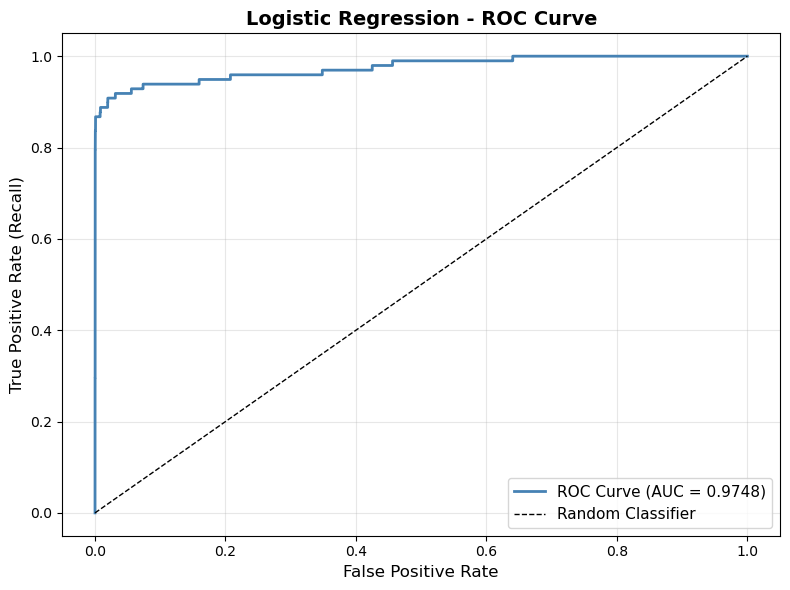


AUC Score: 0.9748


In [16]:
fpr_lr, tpr_lr, thresholds_lr = roc_curve(y_test, y_pred_proba_lr)
auc_lr = auc_score(fpr_lr, tpr_lr)

fig, ax = plt.subplots(figsize=(8, 6))
ax.plot(fpr_lr, tpr_lr, linewidth=2, label=f'ROC Curve (AUC = {auc_lr:.4f})', color='steelblue')
ax.plot([0, 1], [0, 1], 'k--', linewidth=1, label='Random Classifier')
ax.set_xlabel('False Positive Rate', fontsize=12)
ax.set_ylabel('True Positive Rate (Recall)', fontsize=12)
ax.set_title('Logistic Regression - ROC Curve', fontsize=14, fontweight='bold')
ax.legend(fontsize=11)
ax.grid(alpha=0.3)
plt.tight_layout()
plt.show()

print(f"\nAUC Score: {auc_lr:.4f}")


* **ROC Curve:** Đường cong nằm sát góc trên bên trái, cho thấy khả năng phân tách giữa hai lớp (Fraud và Normal) là rất tốt.
* **AUC Score (0.9748):** Chỉ số diện tích dưới đường cong đạt 0.97 là một kết quả **rất cao**.